In [2]:
import os;
import json;
import builtins
import duckdb
import pandas as pd;
import matplotlib.pyplot as plt
import numpy as np

def get_dataset_from_testcase(run):
    return run[6:-2]

dir = '/home/chesetti/Repos/learned_merge_cleanup/sponge/pgm_sampled_debug'
index_stats = []
for test_case in os.listdir(dir):
    if test_case == 'build':
        continue
    for run_name in os.listdir(os.path.join(dir, test_case, 'input_results', 'run')):
        json_file = builtins.open(os.path.join(dir, test_case, 'input_results', 'run', run_name))
        run = (json.load(json_file))
        if 'index_stats' not in run['result']:
            continue
        for run_index_stats in run['result']['index_stats']:
            run_index_stats['dataset'] = get_dataset_from_testcase(test_case)
            index_stats.append(run_index_stats)
idf = pd.json_normalize(index_stats)
print(idf.columns)

Index(['index_build_duration', 'index_load_duration', 'index_name',
       'index_size', 'dataset'],
      dtype='object')


In [3]:
epsilon = {
    "pgm256": 256,
    "pgm1024": 1024,
    "pgm2048": 2048,
    "flatpgm256": 256,
    "flatpgm1024": 1024,
    "flatpgm2048": 2048,
    "sampledpgm256": 256,
    "sampledpgm1024": 1024,
    "sampledpgm2048": 2048,
    "flatpgm4096": 4096,
    "flatpgm8192": 8192,
    "hashjoin": 0,
    "btree256": 256,
    "btree1024": 1024,
    "btree2048": 2048,
    "sj": 0,
    "sj2": 0,
    "standard_merge": 0
};
def indexType(x):
    if "sampledpgm" in x:
        return "SAMPLED_PGM"
    if "flatpgm" in x:
        return "FLAT_PGM"
    elif "pgm" in x:
        return "PGM"
    elif "btree" in x:
        return "BTREE"
    return "NA"
idf['epsilon'] = idf['index_name'].map(lambda x: epsilon[x])
idf['index_type'] = idf['index_name'].map(lambda x: indexType(x))
# Per dataset
rows = duckdb.sql('SELECT * FROM idf')
print(rows)


┌──────────────────────┬─────────────────────┬────────────────┬────────────┬─────────┬─────────┬─────────────┐
│ index_build_duration │ index_load_duration │   index_name   │ index_size │ dataset │ epsilon │ index_type  │
│        int64         │        int64        │    varchar     │   int64    │ varchar │  int64  │   varchar   │
├──────────────────────┼─────────────────────┼────────────────┼────────────┼─────────┼─────────┼─────────────┤
│             78000008 │          1924682694 │ sampledpgm256  │    3189976 │ fb      │     256 │ SAMPLED_PGM │
│             68709757 │          1963802969 │ sampledpgm1024 │     734320 │ fb      │    1024 │ SAMPLED_PGM │
│             60732646 │          1932496408 │ sampledpgm2048 │     280336 │ fb      │    2048 │ SAMPLED_PGM │
│           7013506051 │          3634719059 │ pgm256         │    4143880 │ fb      │     256 │ PGM         │
│           6339254419 │          3657132061 │ pgm1024        │     810544 │ fb      │    1024 │ PGM         │
│

In [30]:
def plot_index_memory(dataset, ax):
    rows = duckdb.sql(f"SELECT index_type, epsilon, index_size FROM idf WHERE dataset='{dataset}'").df()
    rows = rows.pivot(index='epsilon', values='index_size', columns='index_type').dropna()
    x = np.arange(len(rows.index))
    width = 0.15  # the width of the bars
    multiplier = 0
    for column in rows.columns:
        offset = width * multiplier
        rects = ax.bar(x + offset, rows[column], width, label=column)
        multiplier += 1
        ax.bar_label(rects, padding=3)
    ax.set_xticks(x + width, rows.index.astype(str))
    ax.set_ylabel('Size(B)')
    ax.set_xlabel('Epsilon')
    ax.legend(loc='upper right', ncols=3)
    ax.set_title('Index Size')

def plot_index_build(dataset, ax):
    rows = duckdb.sql(f"SELECT index_type, epsilon, index_build_duration FROM idf WHERE dataset='{dataset}'").df()
    rows = rows.pivot(index='epsilon', values='index_build_duration', columns='index_type').dropna()
    x = np.arange(len(rows.index))
    width = 0.25  # the width of the bars
    multiplier = 0
    for column in rows.columns:
        offset = width * multiplier
        rects = ax.bar(x + offset, rows[column], width, label=column)
        multiplier += 1
        ax.bar_label(rects, padding=3)
    ax.set_xticks(x + width, rows.index.astype(str))
    ax.legend(loc='upper right', ncols=3)
    ax.set_ylabel('Duration(ns)')
    ax.set_xlabel('Epsilon')
    ax.legend(loc='upper right', ncols=3)
    ax.set_title('Index Build Duration')
    
def plot_for_dataset(dataset):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))
    plot_index_memory(dataset, ax1)
    plot_index_build(dataset, ax2)
    fig.suptitle(f'dataset={dataset}', fontsize=16)
    plt.show()

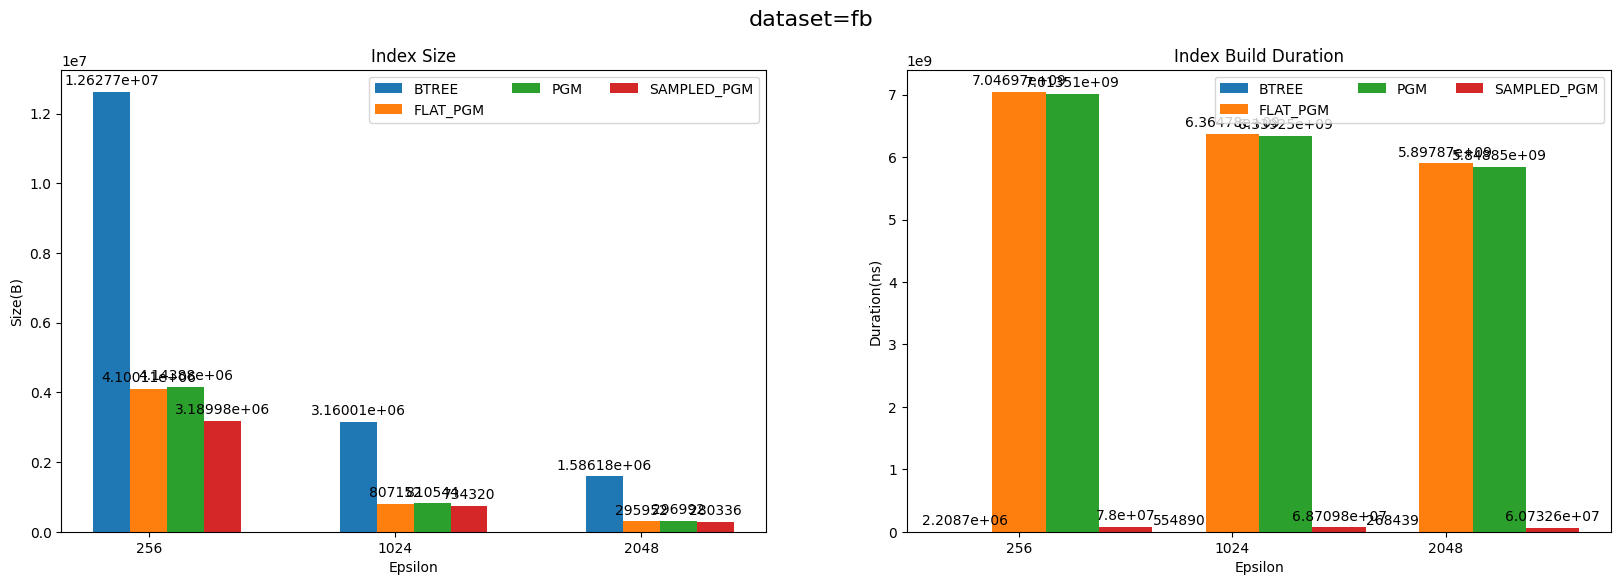

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


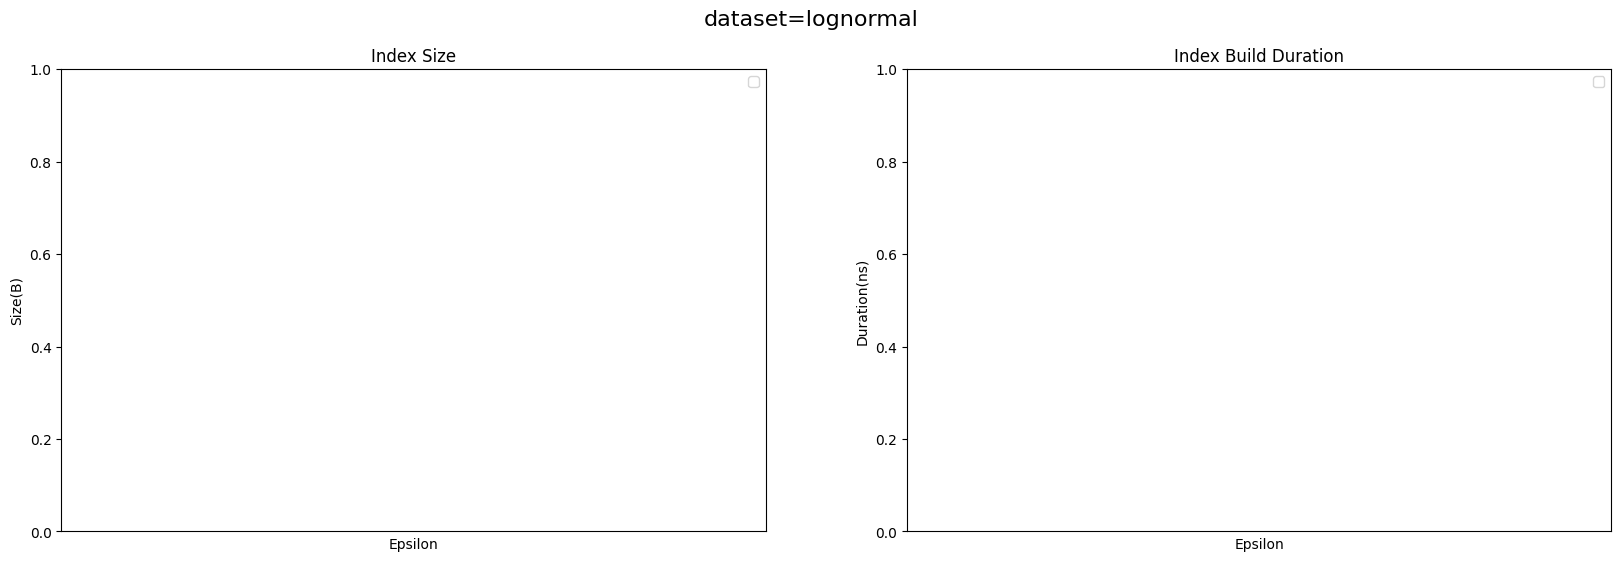

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


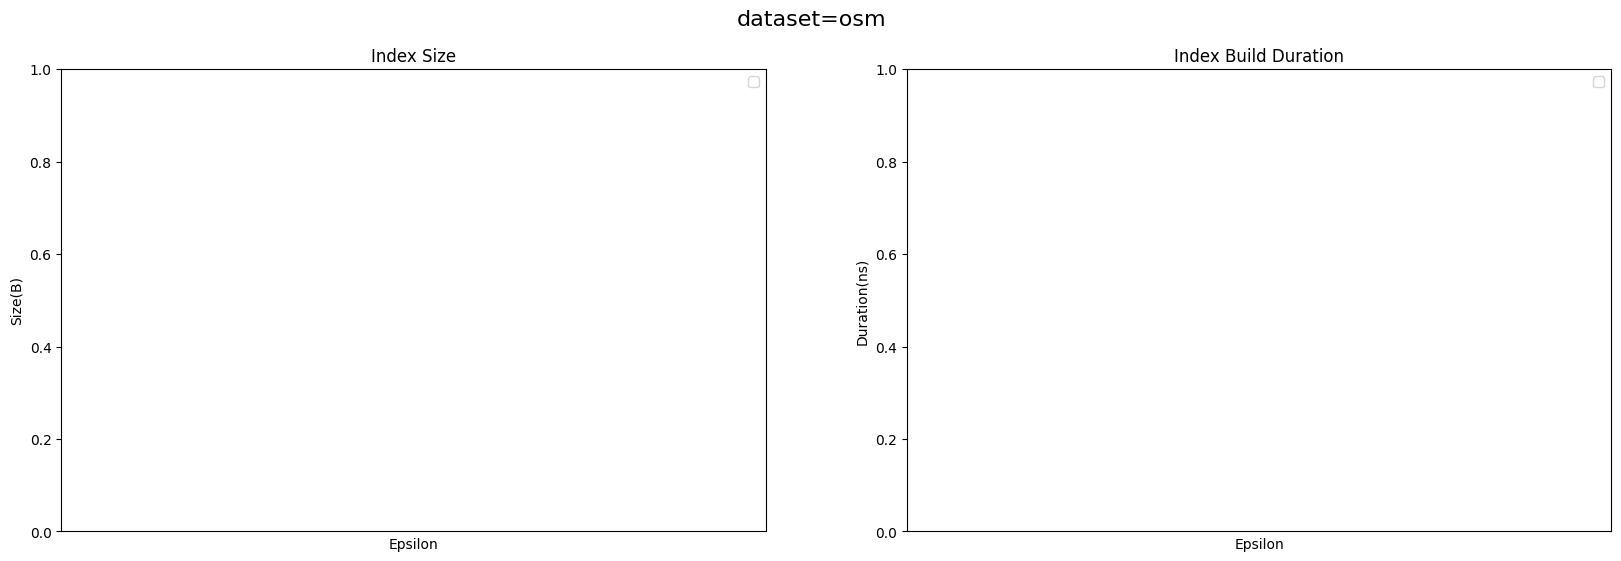

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


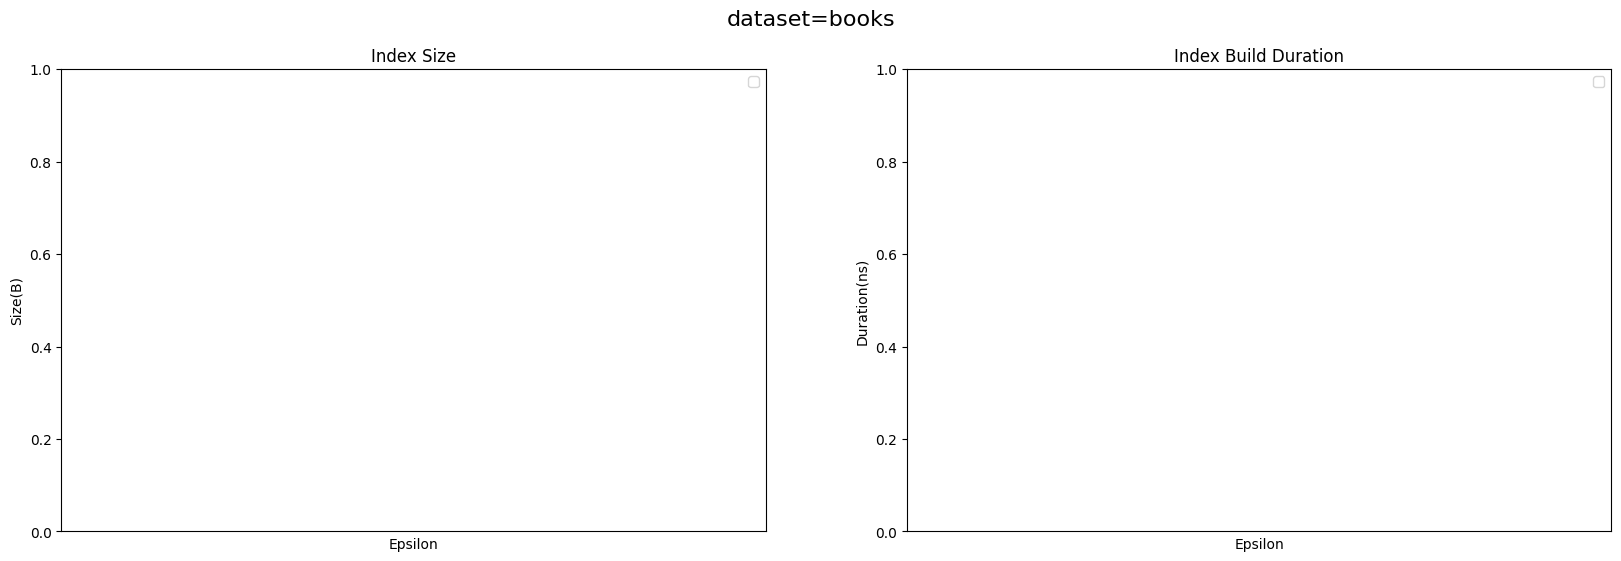

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


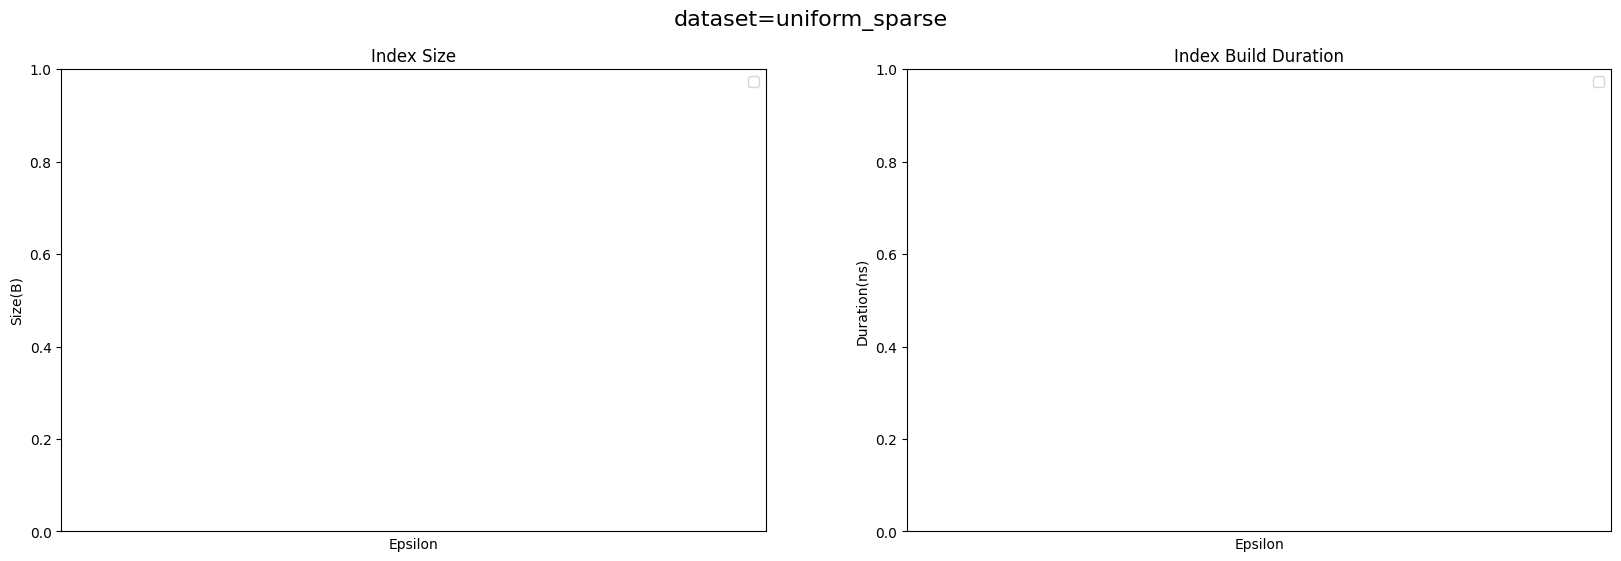

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


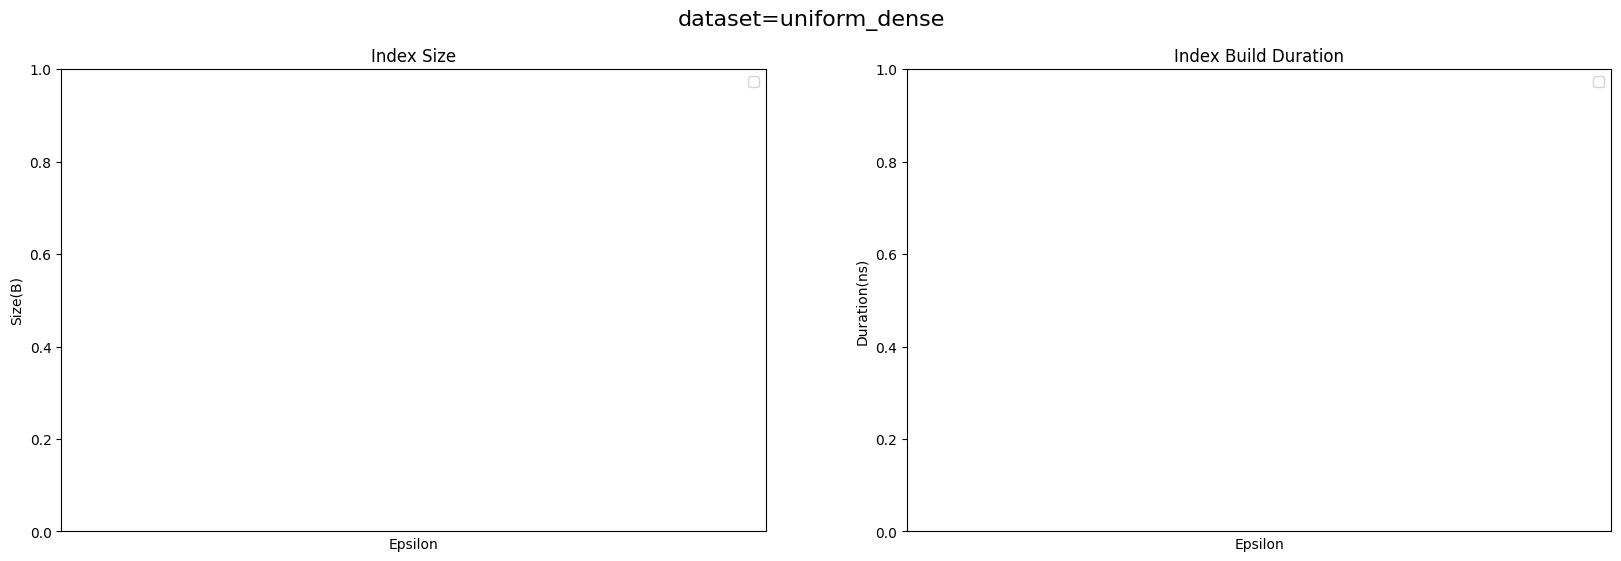

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


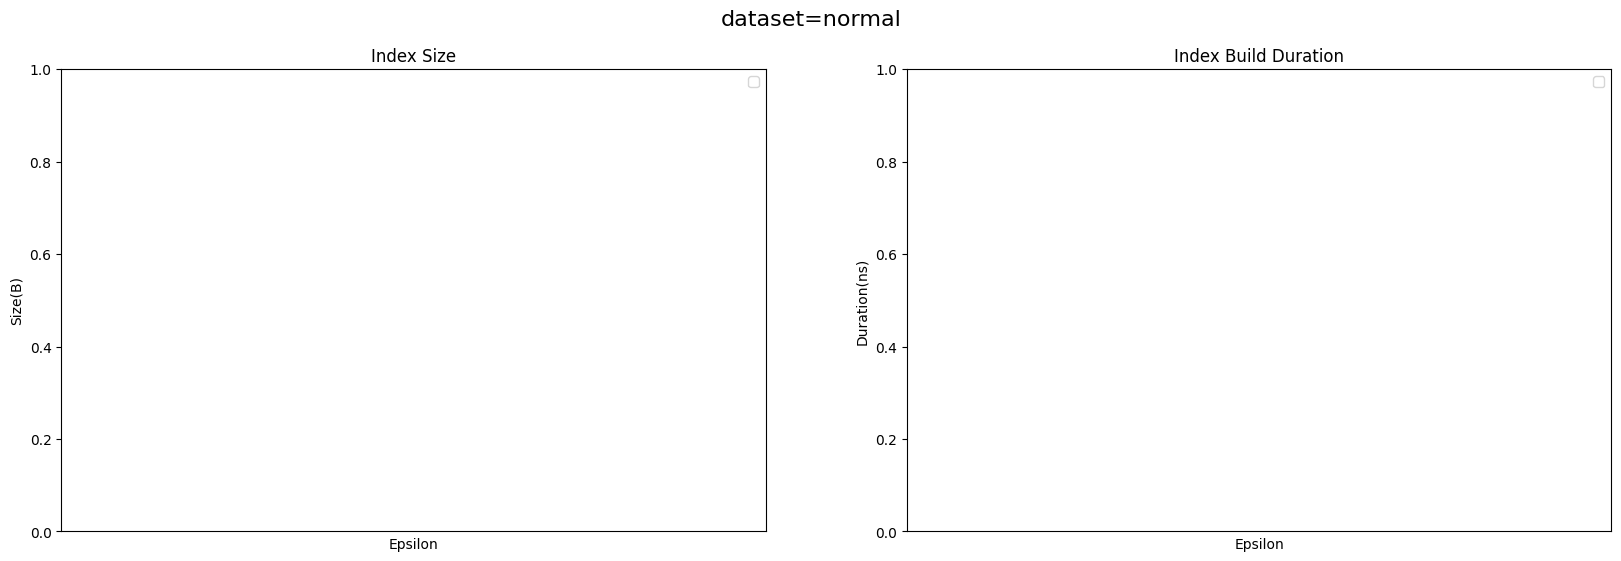

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


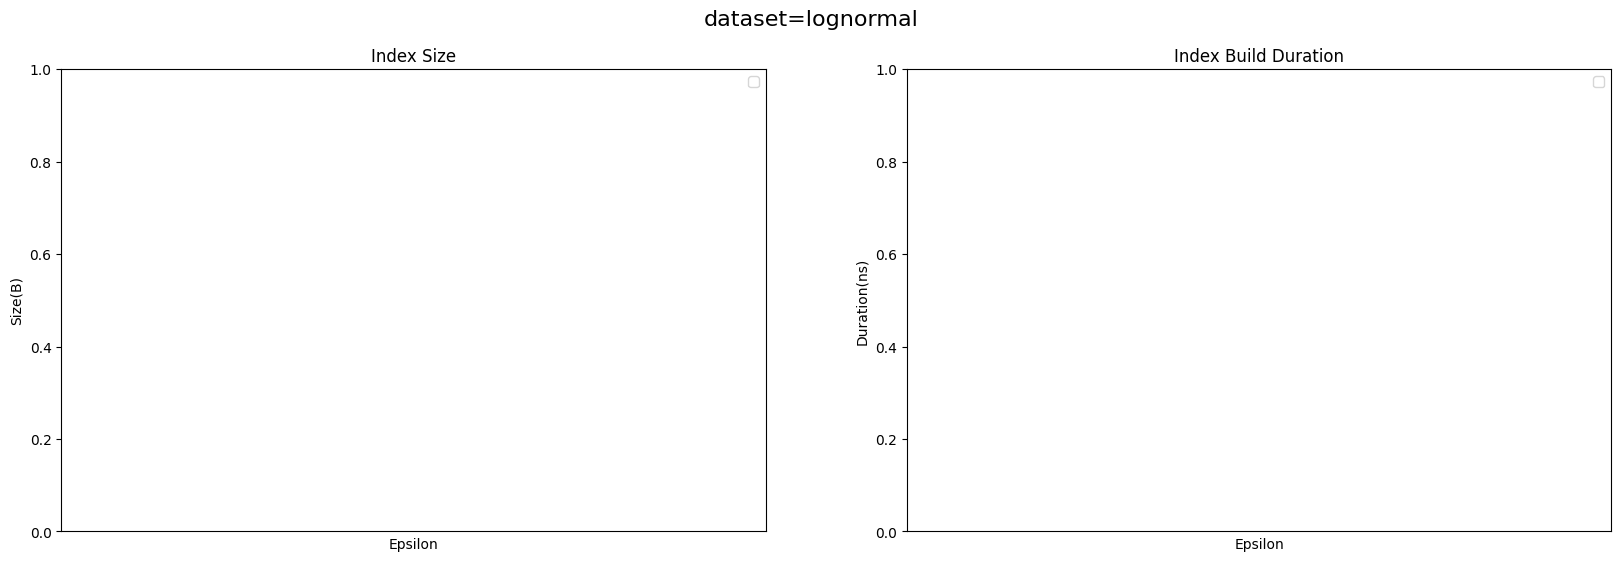

In [31]:
plot_for_dataset('fb')
plot_for_dataset('lognormal')
plot_for_dataset('osm')
plot_for_dataset('books')
plot_for_dataset('uniform_sparse')
plot_for_dataset('uniform_dense')
plot_for_dataset('normal')
plot_for_dataset('lognormal')